**Part I: Define an RL Environment**

In [116]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

Scenario:

Here a firefighters rescue operation is carried out where there is there is one final positive reward[saving a person] and three negative rewards[burning rooms]

Timestep:1, Firefighter Position:0, Action:1,Reward: 0.0


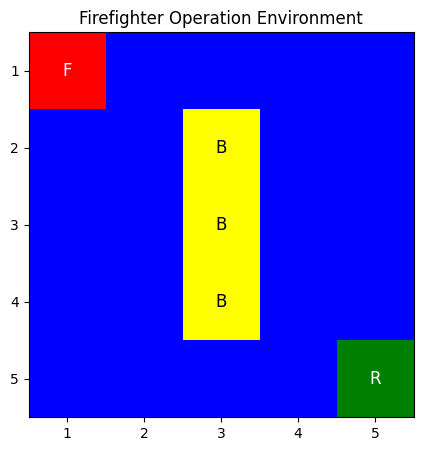

Timestep:2, Firefighter Position:0, Action:1,Reward: 0.0


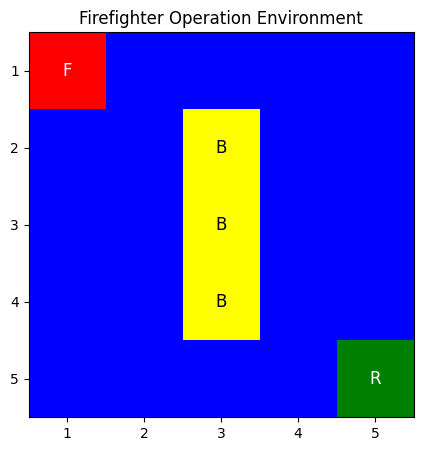

Timestep:3, Firefighter Position:0, Action:1,Reward: 0.0


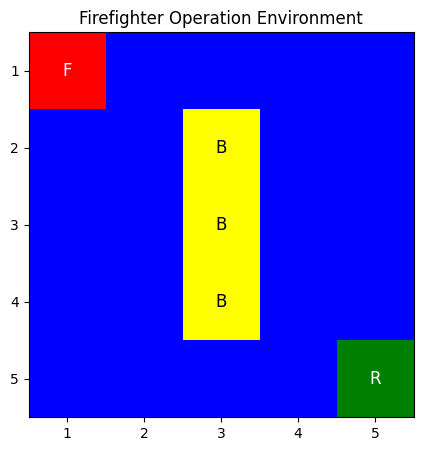

Timestep:4, Firefighter Position:0, Action:3,Reward: 0.0


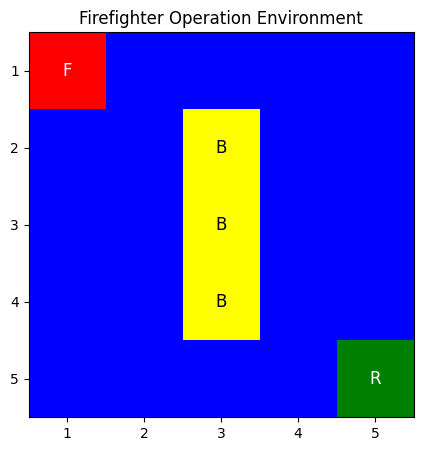

Timestep:5, Firefighter Position:0, Action:1,Reward: 0.0


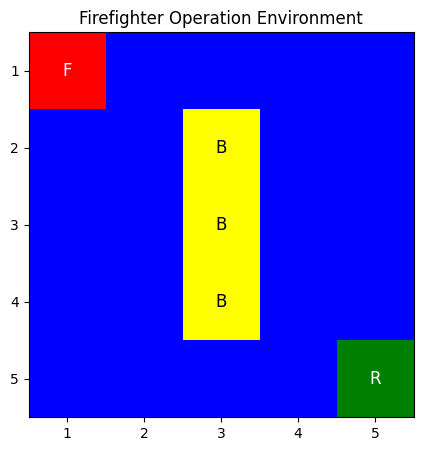

Timestep:6, Firefighter Position:0, Action:3,Reward: 0.0


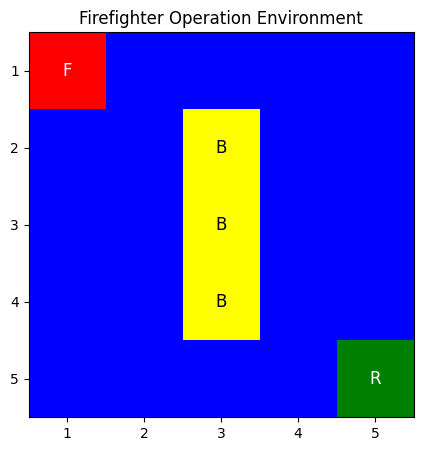

Timestep:7, Firefighter Position:0, Action:1,Reward: 0.0


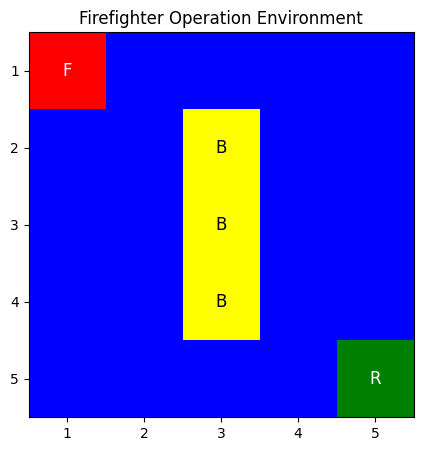

Timestep:8, Firefighter Position:1, Action:2,Reward: 0.0


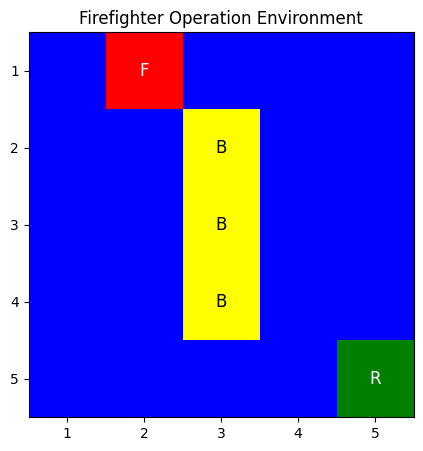

Timestep:9, Firefighter Position:0, Action:3,Reward: 0.0


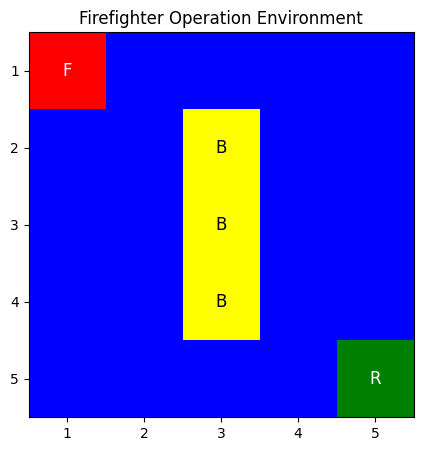

Timestep:10, Firefighter Position:0, Action:3,Reward: 0.0


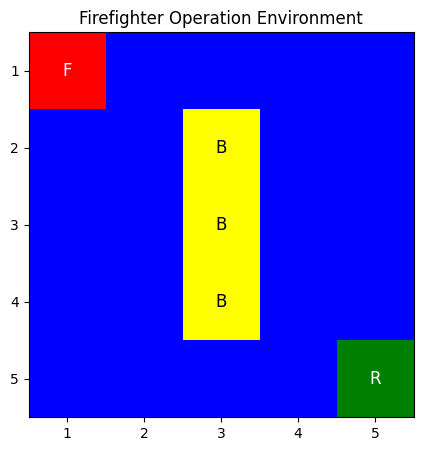

Episode terminated.


In [117]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}
 
    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5  #setting the grid size
        self.max_timesteps = 10  #setting the maximum timesteps
        self.timestep = 0  #initializing the time step

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)  #setting the observation space, 5x5  = 25 squares
        self.action_space = spaces.Discrete(4)  #there are 4 actions - up, down, right, left

        self.rewards = np.zeros((self.grid_size, self.grid_size))  #first we initialize all the rewards to zero
        self.rewards[4, 4] = 20  #this is my final reward square
        self.rewards[1, 2] = -10  #The following three are negative rewards
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10
 
        self.firefighter_position = [0, 0]  #setting the agent position as 0,0

    def reset(self):  #this function is used to reset everything [timesteps, agent position, states]

        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):  #this is for defning the actions for the agents to move

        if action == 0:  #down
            self.firefighter_position[0] += 1
        elif action == 1:  #up
            self.firefighter_position[0] -= 1
        elif action == 2:  #right
            self.firefighter_position[1] += 1
        elif action == 3:  #left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)  #this clips the agent to not move outside the given observation space
        reward = self.rewards[tuple(self.firefighter_position)]  #tupling the rewards
        self.timestep += 1  #increasing the timesteps
        terminated = self.timestep >= self.max_timesteps or reward == 20  #stopping citerion: if the max timesteps is reached or if the reward is reached
        truncated = False 
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):

        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1  # Firefighter
        grid[self.rewards == 20] = 2  # Rescue target
        grid[self.rewards == -10] = 3  # Burning rooms


        cmap = ListedColormap(['blue', 'red', 'green', 'yellow'])  # blue for empty, red for firefighter, green for rescue, yellow for burning rooms
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(grid, cmap=cmap, interpolation='nearest')
        ax.set_xticks(np.arange(self.grid_size))
        ax.set_yticks(np.arange(self.grid_size))
        ax.set_xticklabels(np.arange(1, self.grid_size + 1))
        ax.set_yticklabels(np.arange(1, self.grid_size + 1))

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if grid[i, j] == 1:
                    ax.text(j, i, 'F', ha='center', va='center', color='white', fontsize=12)
                elif grid[i, j] == 2:
                    ax.text(j, i, 'R', ha='center', va='center', color='white', fontsize=12)
                elif grid[i, j] == 3:
                    ax.text(j, i, 'B', ha='center', va='center', color='black', fontsize=12)

        ax.set_title('Firefighter Operation Environment')
        
        plt.show()

    def _get_state(self):

        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]

env = FireFightersOperation()

for t in range(10):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    print(f"Timestep:{t+1}, Firefighter Position:{state}, Action:{action},Reward: {reward}")  #print the state and action info
    env.render()
    if terminated:
        print("Episode terminated.")
        break

**Part 2: Implement SARSA**

Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q-table:
[[-0.02 -0.01 -0.05 -0.01]
 [-0.21 -0.08 -0.38 -0.01]
 [-4.72 -0.33  0.    0.  ]
 [ 0.    0.    0.   -0.31]
 [ 0.    0.    0.    0.  ]
 [-0.06 -0.01 -1.17 -0.12]
 [-0.14 -0.06 -6.97 -0.23]
 [-1.9  -0.14 -0.24 -0.66]
 [ 0.    0.    0.   -2.73]
 [ 0.02  0.    0.    0.  ]
 [-0.   -0.01 -0.55 -0.05]
 [-0.25 -0.41 -4.19 -0.  ]
 [-1.91 -1.01 -0.01 -0.02]
 [-0.08 -0.17  0.   -1.  ]
 [ 0.18  0.    0.    0.  ]
 [ 0.   -0.   -0.08 -0.01]
 [ 0.   -0.15 -2.71  0.  ]
 [-0.07 -1.    0.    0.  ]
 [ 0.    0.    0.   -1.91]
 [ 3.8   0.    0.    0.  ]
 [-0.   -0.01  0.    0.  ]
 [ 0.    0.    0.    0.

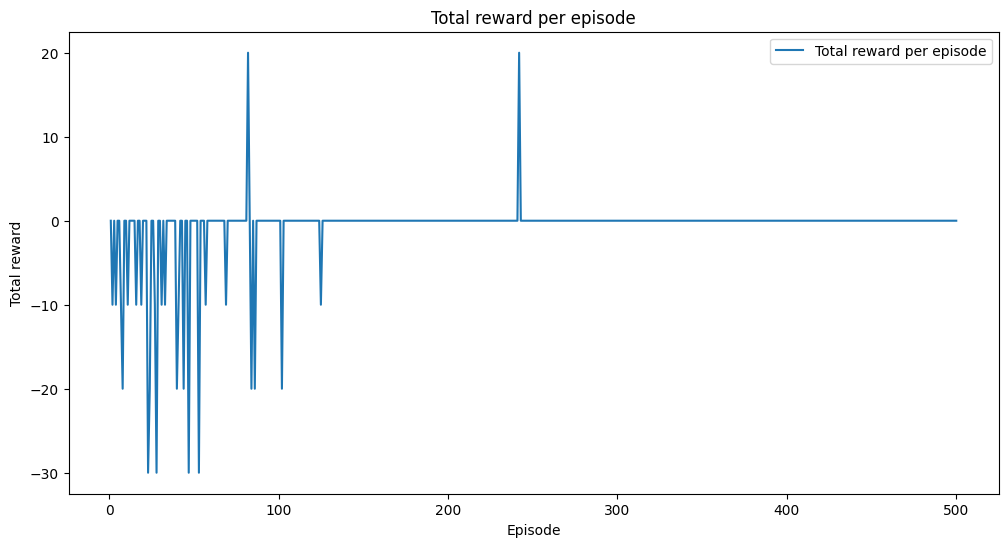

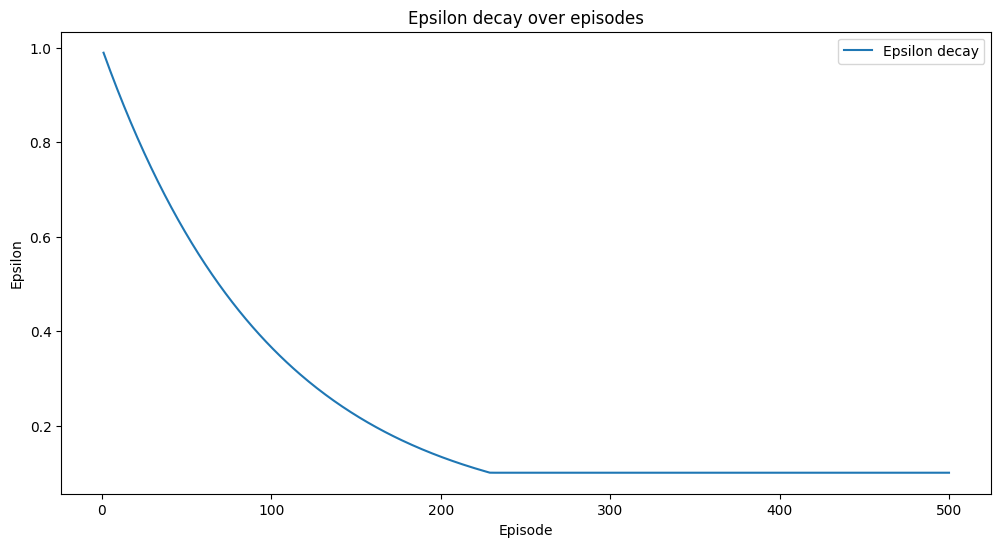

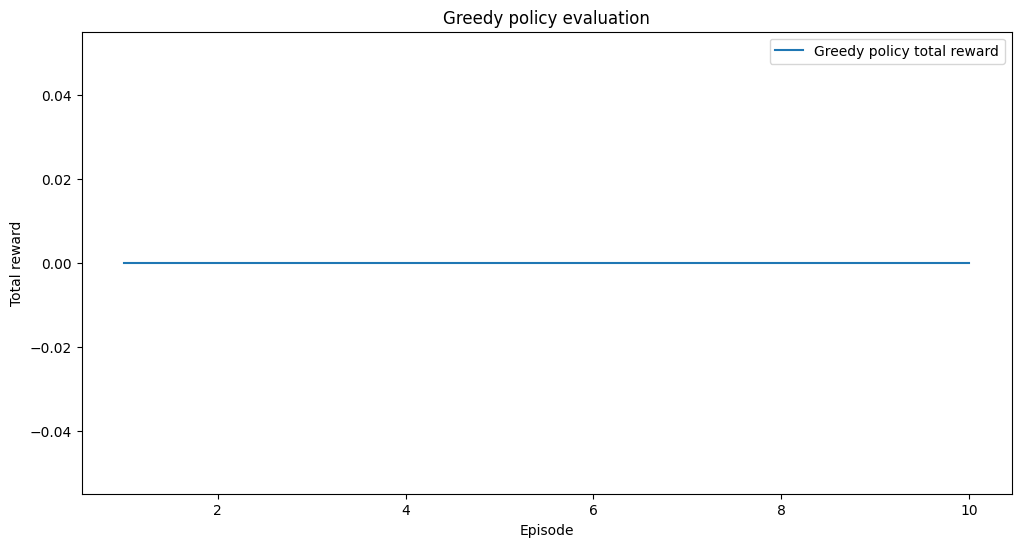

In [118]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4)

        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20
        self.rewards[1, 2] = -10
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10

        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  # Down
            self.firefighter_position[0] += 1
        elif action == 1:  # Up
            self.firefighter_position[0] -= 1
        elif action == 2:  # Right
            self.firefighter_position[1] += 1
        elif action == 3:  # Left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1  #firefighter
        grid[self.rewards == 20] = 2  #rescue target
        grid[self.rewards == -10] = 3  #burning rooms

        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]

#SARSA implementation
def sarsa(env, episodes=500, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()  
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)  #choose A from S using policy defrived from Q[e.g. Epsilon greedy]
        total_reward = 0

        while True:
            next_state, reward, terminated, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n)  #choose A' from S' using policy derived from Q [e.g. Epsilon greedy]

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])  #SARSA update rule
            total_reward += reward
            state, action = next_state, next_action # S <- S' ; A <- A'

            if terminated:
                break  #until S is terminated

        total_rewards.append(total_reward)  #storing the total rewards in the array for GRAPH
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)  #storing the epsilonm values for GRAPH

    return Q, total_rewards, epsilon_values  #returning the values

def epsilon_greedy(Q, state, epsilon, action_space_size):  #epsilon greedy policy
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])

def evaluate_greedy_policy(env, Q, episodes=10): #greedy policy evaluation
    total_rewards = []

    for _ in range(episodes):
        state, _ =env.reset()
        total_reward = 0

        while True:
            action = np.argmax(Q[state])
            next_state, reward, terminated, _, _ =env.step(action)
            total_reward +=reward
            state = next_state
            if terminated:
                break

        total_rewards.append(total_reward)

    return total_rewards

def plot_results(total_rewards, epsilon_values, greedy_rewards):  #plot results
    episodes = np.arange(1, len(total_rewards) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, total_rewards, label="Total reward per episode")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Total reward per episode")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, epsilon_values, label="Epsilon decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay over episodes")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(greedy_rewards) + 1), greedy_rewards, label="Greedy policy total reward")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Greedy policy evaluation")
    plt.legend()
    plt.show()

env = FireFightersOperation()
initial_Q = np.zeros((env.observation_space.n, env.action_space.n))
print("Initial Q-table:")
print(initial_Q)
trained_Q, total_rewards, epsilon_values = sarsa(env)
print("Trained Q-table:")
print(trained_Q)
greedy_rewards = evaluate_greedy_policy(env, trained_Q)
plot_results(total_rewards, epsilon_values, greedy_rewards)


Hyperparameter tuning

Im doing manual tuning of the hyperparameters

Gamma:0.8, Epsilon Decay:0.9, Average Rewards:0.0
Gamma:0.8, Epsilon Decay:0.95, Average Rewards:0.0
Gamma:0.8, Epsilon Decay:0.99, Average Rewards:0.0
Gamma:0.9, Epsilon Decay:0.9, Average Rewards:0.0
Gamma:0.9, Epsilon Decay:0.95, Average Rewards:0.0
Gamma:0.9, Epsilon Decay:0.99, Average Rewards:11.6
Gamma:0.95, Epsilon Decay:0.9, Average Rewards:0.0
Gamma:0.95, Epsilon Decay:0.95, Average Rewards:0.8
Gamma:0.95, Epsilon Decay:0.99, Average Rewards:15.8
Best Parameters:
{'gamma': 0.95, 'epsilon_decay': 0.99}


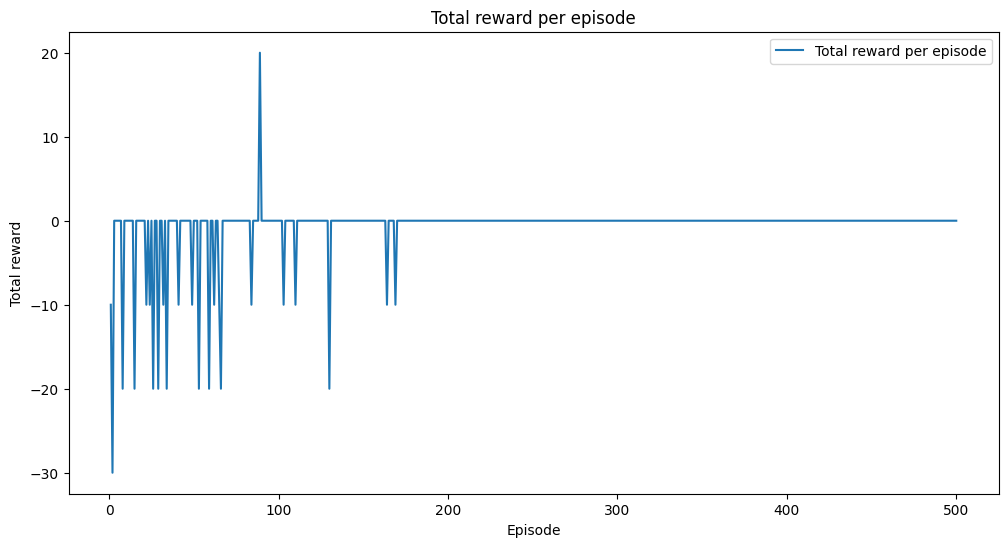

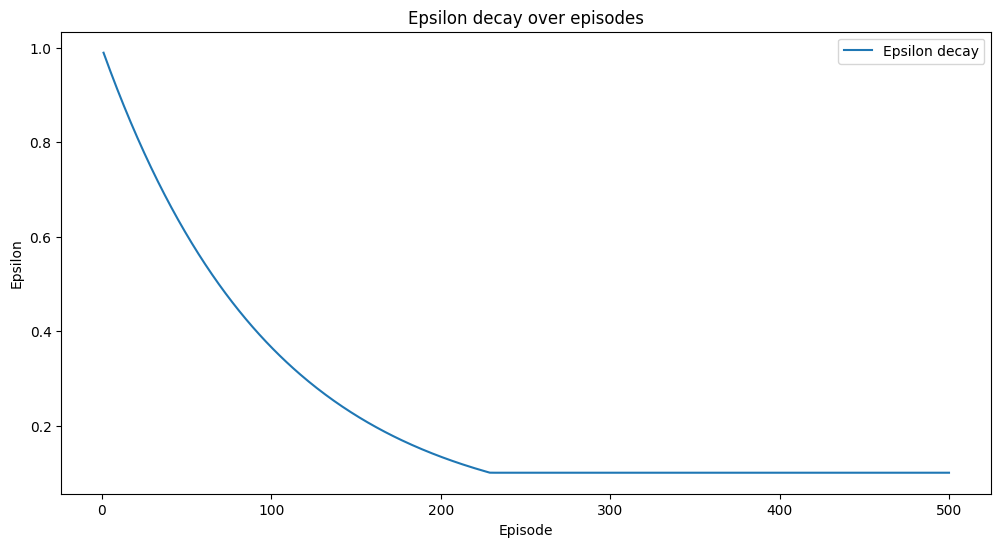

In [119]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()
        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0
        self.observation_space = gym.spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = gym.spaces.Discrete(4)
        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20
        self.rewards[1, 2] = -10
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10
        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  # Down
            self.firefighter_position[0] += 1
        elif action == 1:  # Up
            self.firefighter_position[0] -= 1
        elif action == 2:  # Right
            self.firefighter_position[1] += 1
        elif action == 3:  # Left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1  
        grid[self.rewards == 20] = 2  
        grid[self.rewards == -10] = 3 
        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]


def sarsa(env, episodes=500, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)
        total_reward = 0

        while True:
            next_state, reward, terminated, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n)

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            total_reward += reward
            state, action = next_state, next_action

            if terminated:
                break

        total_rewards.append(total_reward)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return Q, total_rewards, epsilon_values


def epsilon_greedy(Q, state, epsilon, action_space_size):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])


def plot_results(total_rewards, epsilon_values):
    episodes = np.arange(1, len(total_rewards) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, total_rewards, label="Total reward per episode")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Total reward per episode")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, epsilon_values, label="Epsilon decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay over episodes")
    plt.legend()
    plt.show()

env = FireFightersOperation()

gamma_values = [0.8, 0.9, 0.95]  #choosing hyperparameters
epsilon_decay_values = [0.90, 0.95, 0.99]

best_Q = None
best_rewards = -float('inf')
best_params = {}

for gamma in gamma_values:
    for epsilon_decay in epsilon_decay_values:
        Q, total_rewards, epsilon_values = sarsa(env, gamma=gamma, epsilon_decay=epsilon_decay)
        average_rewards = np.mean(total_rewards[-50:])

        print(f"Gamma:{gamma}, Epsilon Decay:{epsilon_decay}, Average Rewards:{average_rewards}")

        if average_rewards > best_rewards:
            best_rewards = average_rewards
            best_Q = Q
            best_params = {'gamma':gamma, 'epsilon_decay':epsilon_decay}

print("Best Parameters:")
print(best_params)
final_Q, total_rewards, epsilon_values = sarsa(env, gamma=best_params['gamma'], epsilon_decay=best_params['epsilon_decay'])
plot_results(total_rewards, epsilon_values)

The graphs of the best model are given above

From the above experiment we can see that the best model will be with the hyperparameters with {'gamma': 0.95, 'epsilon_decay': 0.99}

**REFERENCES:**

Class lectures/slides on SARSA and Epsilon greedy algorithm

Professor Alina Vereschaka recordings:

https://ubuffalo-my.sharepoint.com/personal/avereshc_buffalo_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Favereshc%5Fbuffalo%5Fedu%2FDocuments%2F2024%5FFall%5FRL%2F%5Fpublic%2FCourse%20Materials%2FRL%20Environment%20Visualization&ga=1

RL Environment Demo:

https://ubuffalo-my.sharepoint.com/personal/avereshc_buffalo_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Favereshc%5Fbuffalo%5Fedu%2FDocuments%2F2024%5FFall%5FRL%2F%5Fpublic%2FCourse%20Materials%2FRL%20Environment%20Demo&ga=1

Part 3: Double Q learning 

Initial Q1 Table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Initial Q2 Table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q1 Table:
[[ 2.68 13.66 20.82 12.44]
 [ 6.5  12.97 25.03  9.43]
 [-1.69 23.61 20.   16.37]
 [ 0.61 21.11 13.93 25.56]
 [ 0.    5.76  1.41 18.02]
 [ 0.    4.56  2.21  0.68]
 [ 0.05 10.36  0.61  0.18]
 [-3.

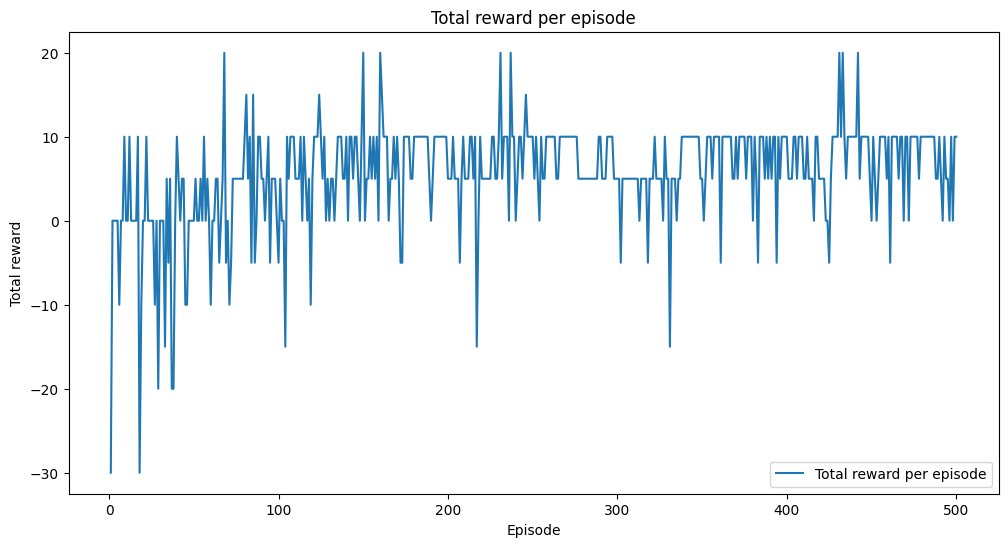

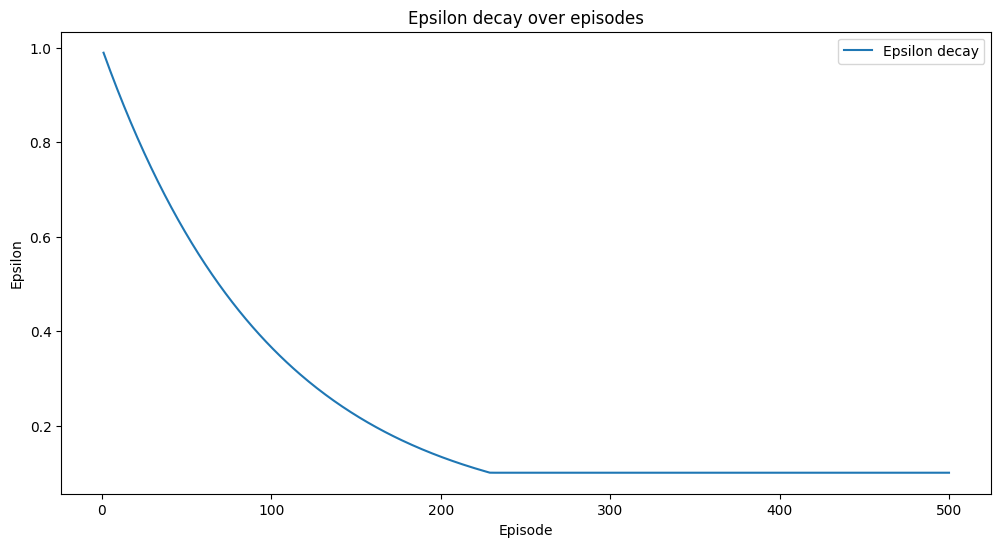

In [120]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4)

        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20  
        self.rewards[1, 2] = -10
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10

        
        self.rewards[0, 2] = 5  
        self.rewards[4, 2] = 10 

        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  #down
            self.firefighter_position[0] += 1
        elif action == 1:  #up
            self.firefighter_position[0] -= 1
        elif action == 2:  #right
            self.firefighter_position[1] += 1
        elif action == 3:  #left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1 
        grid[self.rewards == 20] = 2 
        grid[self.rewards == -10] = 3 

        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]


def epsilon_greedy(Q, state, epsilon, action_space_size):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])


def double_q_learning_n_step(env, episodes=500, n=5, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))

    initial_Q1 = Q1.copy()
    initial_Q2 = Q2.copy()

    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q1, state, epsilon, env.action_space.n)
        rewards = 0
        trajectory = []

        for t in range(n):
            next_state, reward, terminated, _, _ = env.step(action)
            trajectory.append((state, action, reward, next_state))
            state, action = next_state, epsilon_greedy(Q1, state, epsilon, env.action_space.n)
            rewards += reward
            if terminated:
                break

        for step in reversed(range(len(trajectory))):
            state, action, reward, next_state = trajectory[step]

            if step == len(trajectory) - 1:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])
            else:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        total_rewards.append(rewards)
        epsilon_values.append(epsilon)

    return initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values


def plot_results(total_rewards, epsilon_values):
    episodes = np.arange(1, len(total_rewards) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, total_rewards, label="Total reward per episode")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Total reward per episode")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, epsilon_values, label="Epsilon decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay over episodes")
    plt.legend()
    plt.show()


env = FireFightersOperation()
initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values = double_q_learning_n_step(env)

print("Initial Q1 Table:")
print(initial_Q1)
print("Initial Q2 Table:")
print(initial_Q2)

print("Trained Q1 Table:")
print(Q1)
print("Trained Q2 Table:")
print(Q2)

plot_results(total_rewards, epsilon_values)


Manual Hyperparameter tuning  nad printing the best model

Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, n=5
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, n=10
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, n=20
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, n=5
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, n=10
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, n=20
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, n=5
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, n=10
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, n=20
Training with alpha=0.1, gamma=0.9, epsilon=0.8, epsilon_decay=0.99, n=5
Training with alpha=0.1, gamma=0.9, epsilon=0.8, epsilon_decay=0.99, n=10
Training with alpha=0.1, gamma=0.9, epsilon=0.8, epsilon_decay=0.99, n=20
Training with alpha=0.1, gamma=0.9, epsilon=0.8, epsilon_decay=0.995, n=5
Training with alpha=0.1, gamma=0.9, 

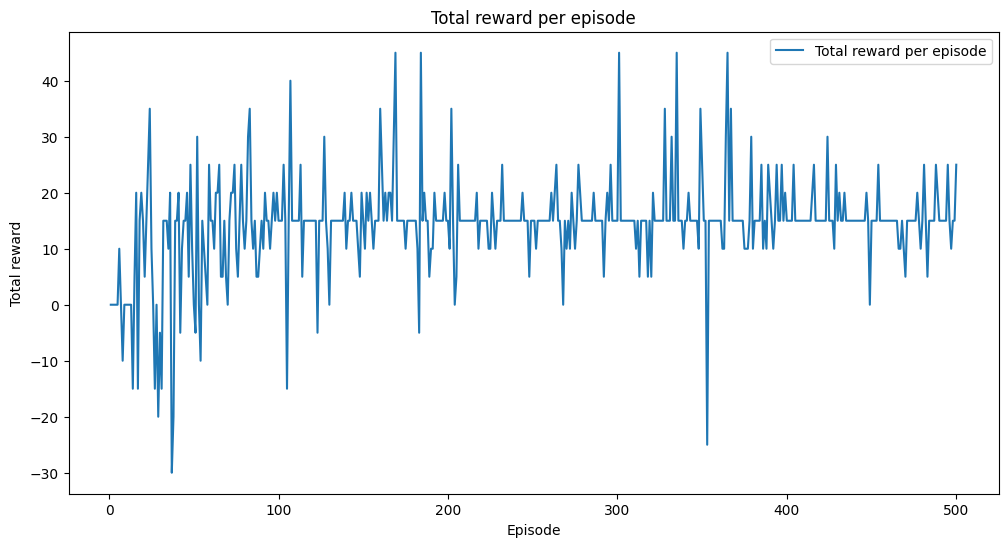

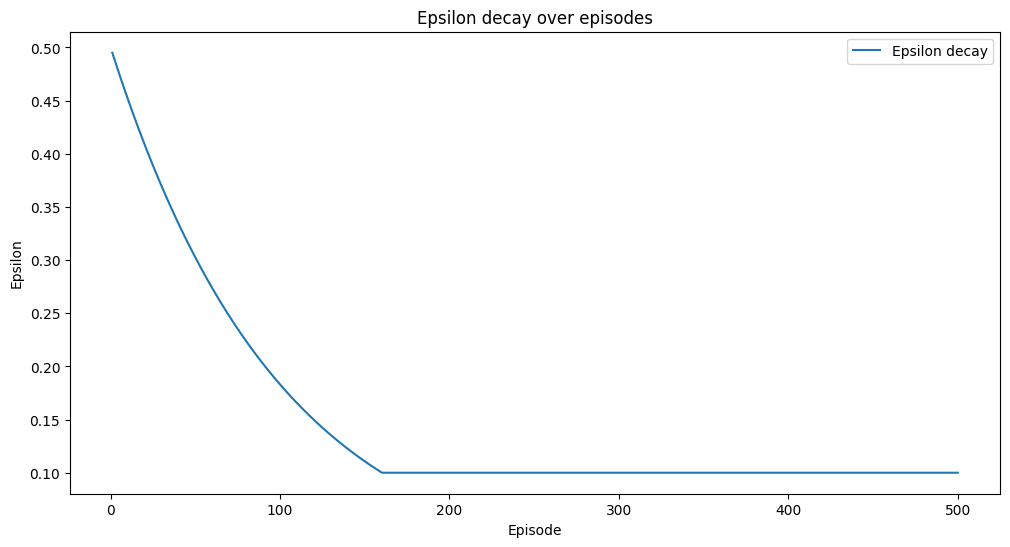

In [121]:
import itertools

class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4)

        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20 
        self.rewards[1, 2] = -10  
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10

        self.rewards[0, 2] = 5  
        self.rewards[4, 2] = 10  

        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  #down
            self.firefighter_position[0] += 1
        elif action == 1:  #up
            self.firefighter_position[0] -= 1
        elif action == 2:  #right
            self.firefighter_position[1] += 1
        elif action == 3:  #left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1  
        grid[self.rewards == 20] = 2
        grid[self.rewards == -10] = 3 

        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]

def epsilon_greedy(Q, state, epsilon, action_space_size):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])

def double_q_learning_n_step(env, episodes=500, n=5, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))

    initial_Q1 = Q1.copy()
    initial_Q2 = Q2.copy()

    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q1, state, epsilon, env.action_space.n)
        rewards = 0
        trajectory = []

        for t in range(n):
            next_state, reward, terminated, _, _ = env.step(action)
            trajectory.append((state, action, reward, next_state))
            state, action = next_state, epsilon_greedy(Q1, state, epsilon, env.action_space.n)
            rewards += reward
            if terminated:
                break

        for step in reversed(range(len(trajectory))):
            state, action, reward, next_state = trajectory[step]

            if step == len(trajectory) - 1:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])
            else:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        total_rewards.append(rewards)
        epsilon_values.append(epsilon)

    return initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values


#Hyperparameter tuning using Grid Search
def tune_hyperparameters(env):
    alpha_values = [0.1, 0.01, 0.001]
    gamma_values = [0.9, 0.95, 0.99]
    epsilon_values = [1.0, 0.8, 0.5]
    epsilon_decay_values = [0.99, 0.995, 0.999]
    n_values = [5, 10, 20]

    param_grid = itertools.product(alpha_values, gamma_values, epsilon_values, epsilon_decay_values, n_values)

    results = []

    for params in param_grid:
        alpha, gamma, epsilon, epsilon_decay, n = params
        print(f"Training with alpha={alpha}, gamma={gamma}, epsilon={epsilon}, epsilon_decay={epsilon_decay}, n={n}")

        initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_history = double_q_learning_n_step(
            env,
            episodes=500,
            n=n,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            epsilon_decay=epsilon_decay,
            min_epsilon=0.1
        )

        avg_reward = np.mean(total_rewards[-100:])
        results.append((params, avg_reward))

    best_params, best_reward = max(results, key=lambda x: x[1])
    print(f"Best hyperparameters: {best_params} with average reward: {best_reward}")
    return best_params


def plot_results(total_rewards, epsilon_values):
    episodes = np.arange(1, len(total_rewards) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, total_rewards, label="Total reward per episode")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Total reward per episode")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, epsilon_values, label="Epsilon decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay over episodes")
    plt.legend()
    plt.show()


env = FireFightersOperation()
best_params = tune_hyperparameters(env)

alpha, gamma, epsilon, epsilon_decay, n = best_params
initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values = double_q_learning_n_step(
    env,
    episodes=500,
    n=n,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    min_epsilon=0.1
)

print("Initial Q1 Table:")
print(initial_Q1)
print("Initial Q2 Table:")
print(initial_Q2)

print("Trained Q1 Table:")
print(Q1)
print("Trained Q2 Table:")
print(Q2)

# Plot results
plot_results(total_rewards, epsilon_values)


n-steps Q-learning

Running Double Q-Learning with n=1


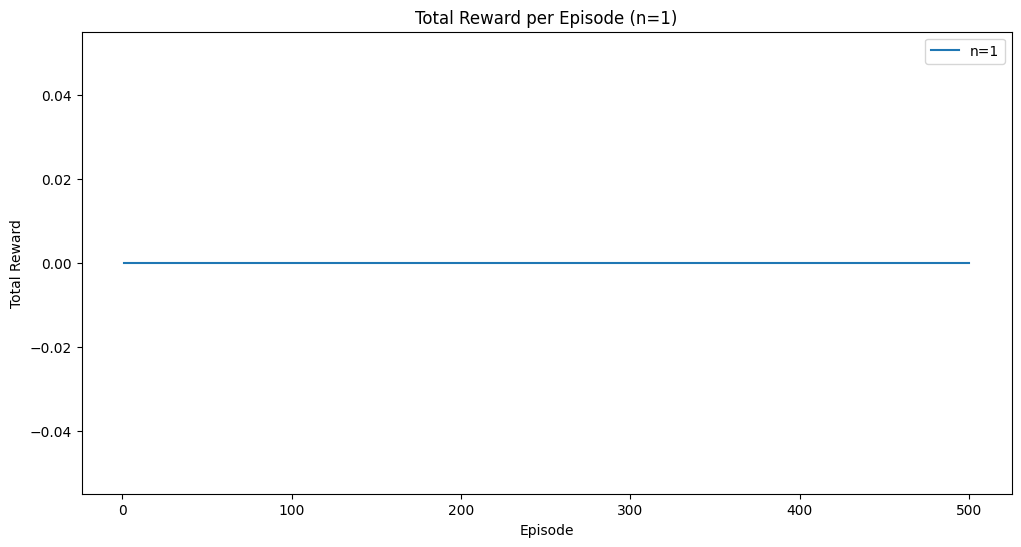

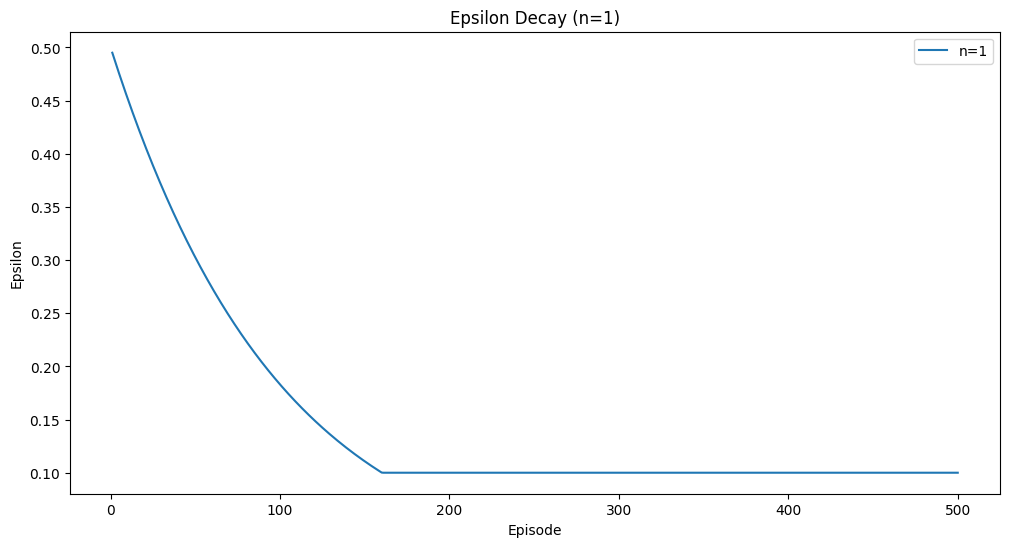

Running Double Q-Learning with n=2


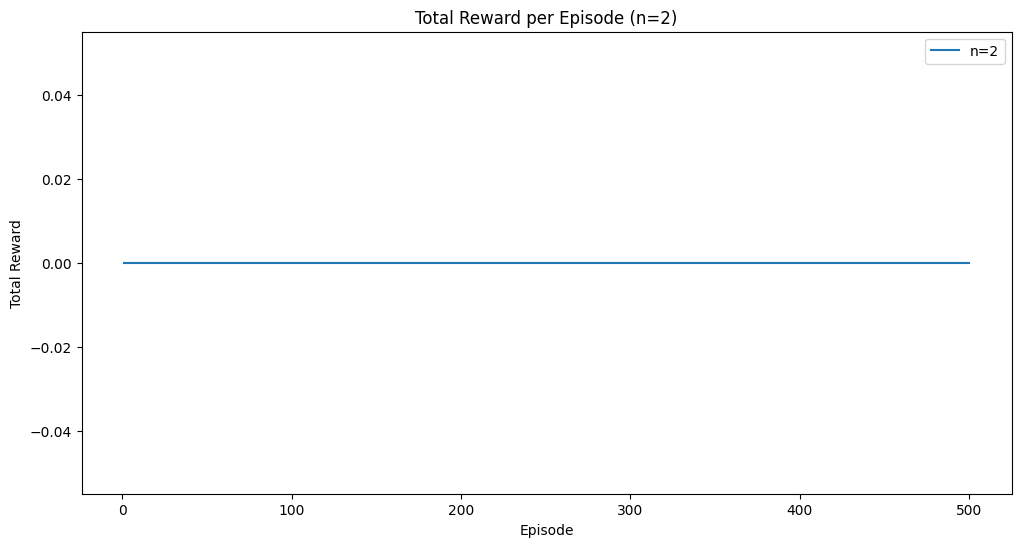

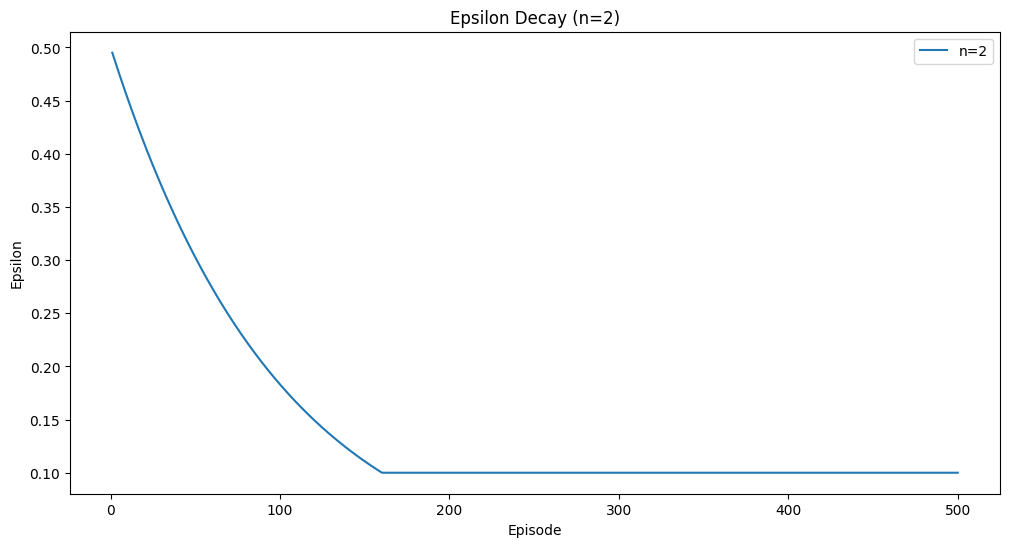

Running Double Q-Learning with n=3


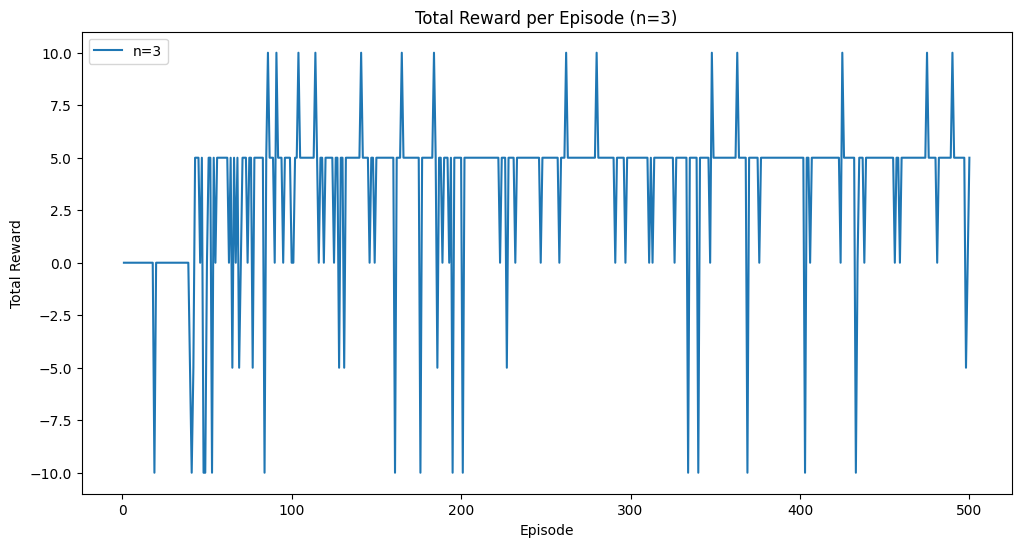

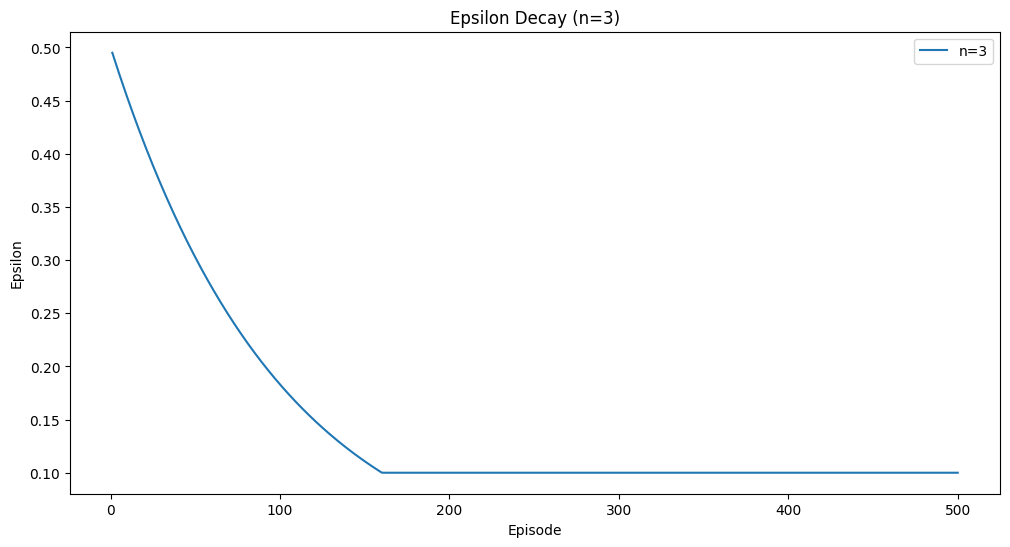

Running Double Q-Learning with n=4


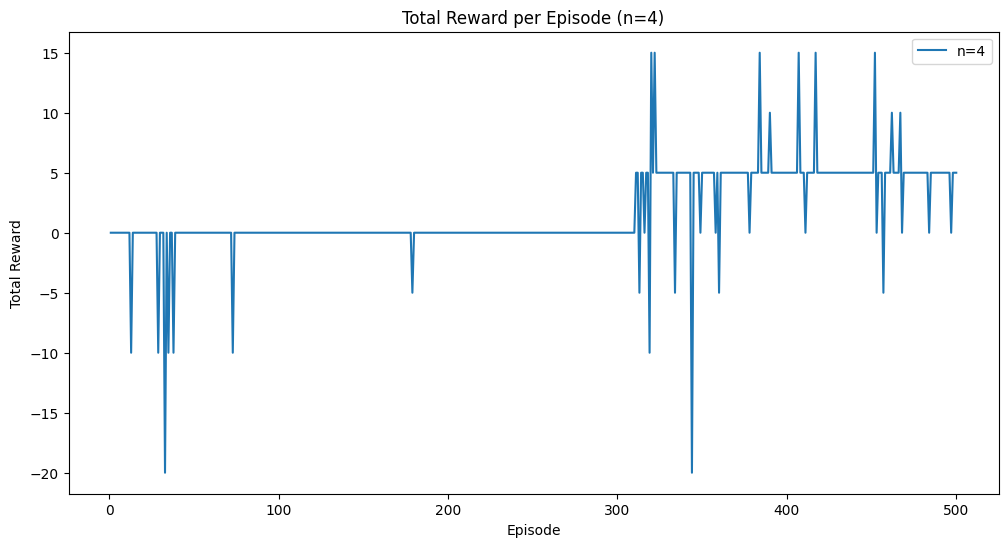

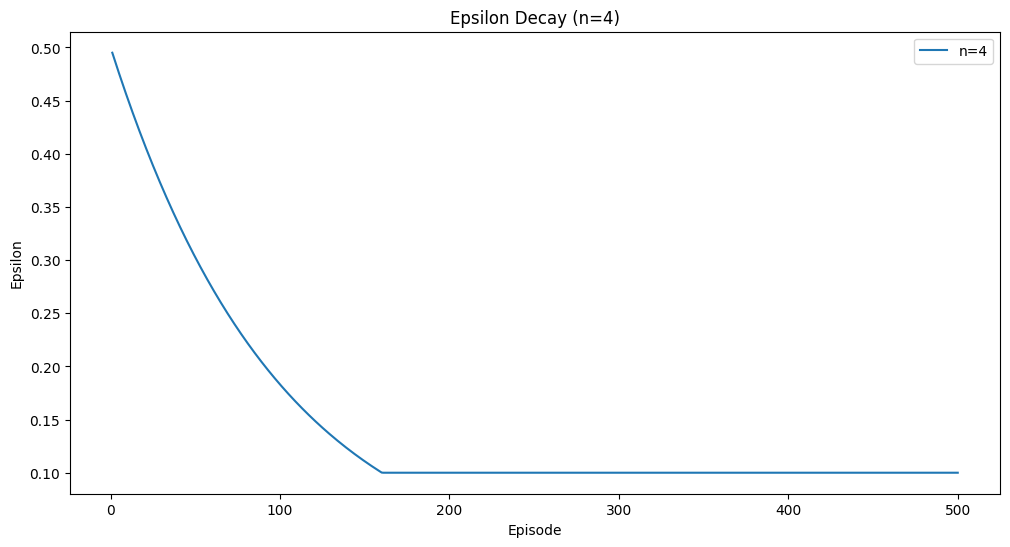

Running Double Q-Learning with n=5


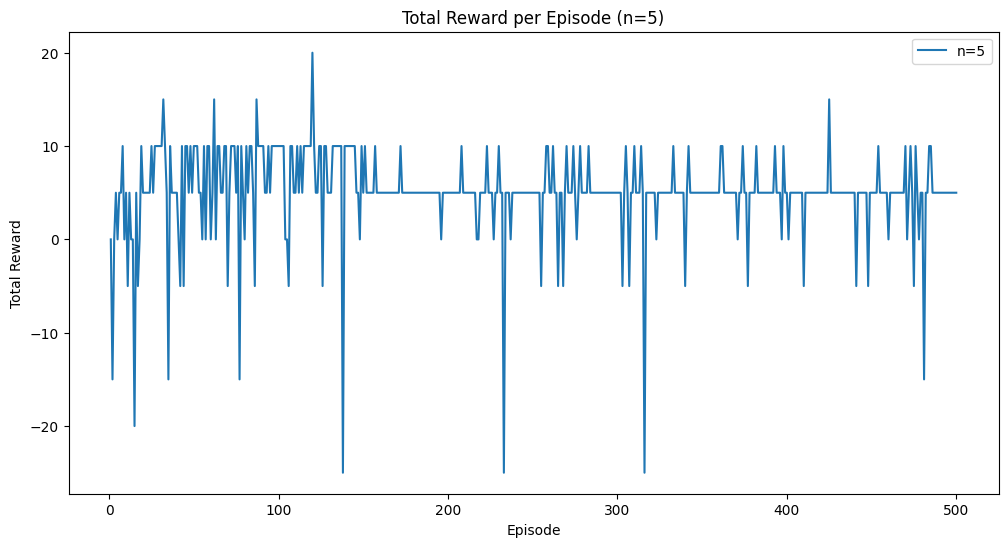

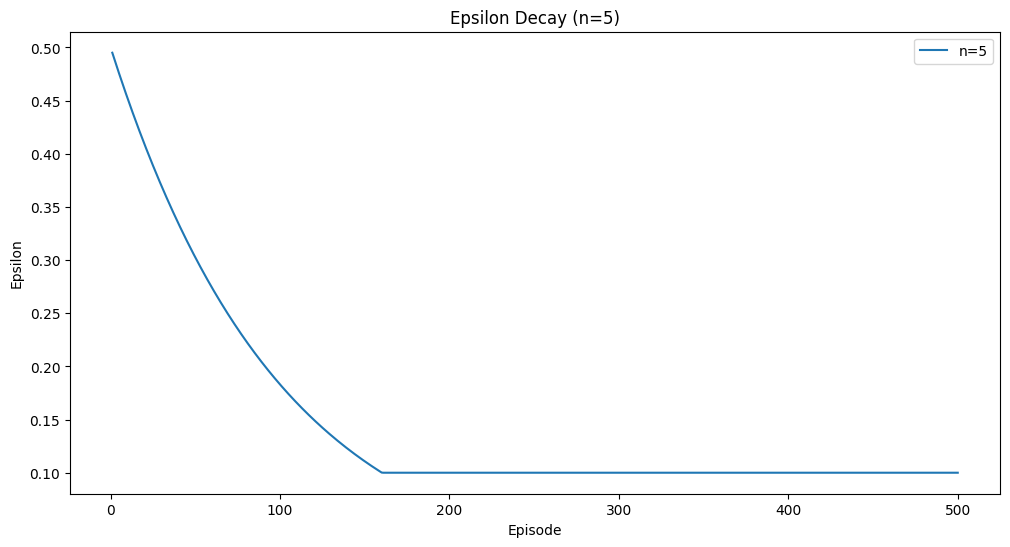

Evaluating greedy performance for n=1
Total reward for 10 episodes with greedy actions (n=1): 0.0
Evaluating greedy performance for n=2
Total reward for 10 episodes with greedy actions (n=2): 0.0
Evaluating greedy performance for n=3
Total reward for 10 episodes with greedy actions (n=3): 45.0
Evaluating greedy performance for n=4
Total reward for 10 episodes with greedy actions (n=4): 45.0
Evaluating greedy performance for n=5
Total reward for 10 episodes with greedy actions (n=5): 25.0


In [123]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4)

        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20 
        self.rewards[1, 2] = -10 
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10

        self.rewards[0, 2] = 5 
        self.rewards[4, 2] = 10

        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  #down
            self.firefighter_position[0] += 1
        elif action == 1:  #up
            self.firefighter_position[0] -= 1
        elif action == 2:  #right
            self.firefighter_position[1] += 1
        elif action == 3:  #left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1 
        grid[self.rewards == 20] = 2 
        grid[self.rewards == -10] = 3  

        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]

def epsilon_greedy(Q, state, epsilon, action_space_size):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])

def double_q_learning_n_step(env, episodes=500, n=5, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))

    initial_Q1 = Q1.copy()
    initial_Q2 = Q2.copy()

    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q1, state, epsilon, env.action_space.n)
        rewards = 0
        trajectory = []

        for t in range(n):
            next_state, reward, terminated, _, _ = env.step(action)
            trajectory.append((state, action, reward, next_state))
            state, action = next_state, epsilon_greedy(Q1, state, epsilon, env.action_space.n)
            rewards += reward
            if terminated:
                break

        for step in reversed(range(len(trajectory))):
            state, action, reward, next_state = trajectory[step]

            if step == len(trajectory) - 1:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])
            else:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        total_rewards.append(rewards)
        epsilon_values.append(epsilon)

    return initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values

alpha = 0.01
gamma = 0.95
epsilon = 0.5
epsilon_decay = 0.99
episodes = 500
n_values = [1, 2, 3, 4, 5]

all_results = {}

for n in n_values:
    print(f"Running Double Q-Learning with n={n}")
    initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values = double_q_learning_n_step(
        env,
        episodes=episodes,
        n=n,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        min_epsilon=0.1
    )
    
    all_results[n] = {
        'initial_Q1': initial_Q1,
        'initial_Q2': initial_Q2,
        'Q1': Q1,
        'Q2': Q2,
        'total_rewards': total_rewards,
        'epsilon_values': epsilon_values
    }

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, episodes + 1), total_rewards, label=f'n={n}')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(f'Total Reward per Episode (n={n})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, episodes + 1), epsilon_values, label=f'n={n}')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title(f'Epsilon Decay (n={n})')
    plt.legend()
    plt.show()

for n in n_values:
    print(f"Evaluating greedy performance for n={n}")
    
    Q1 = all_results[n]['Q1']
    Q2 = all_results[n]['Q2']

    total_rewards = []
    for _ in range(10):
        state, _ = env.reset()
        rewards = 0
        terminated = False
        while not terminated:
            action = np.argmax(Q1[state] + Q2[state]) 
            next_state, reward, terminated, _, _ = env.step(action)
            rewards += reward
            state = next_state
        total_rewards.append(rewards)
    
    print(f"Total reward for 10 episodes with greedy actions (n={n}): {np.mean(total_rewards)}")



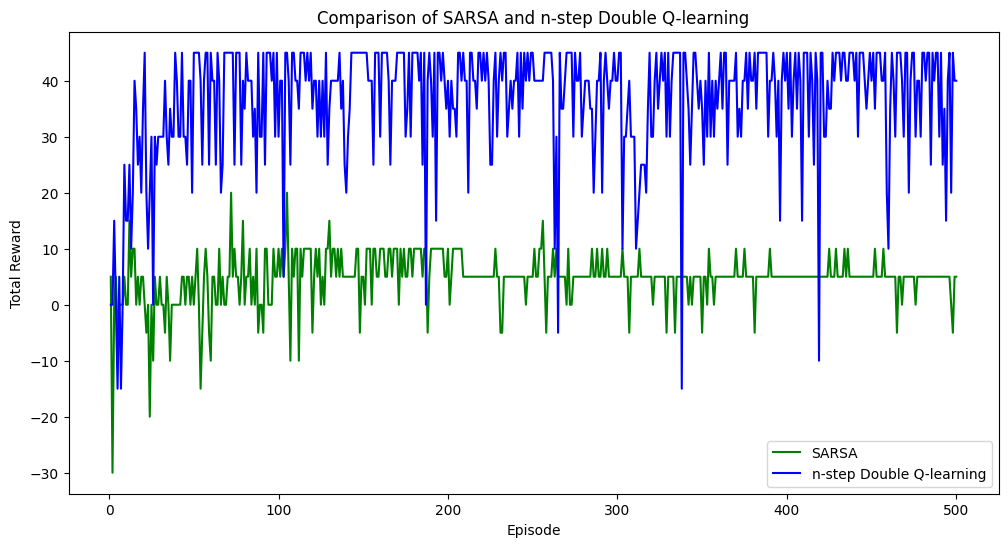

In [125]:
#running SARSA
sarsa_Q, sarsa_rewards, sarsa_epsilon_values = sarsa(env, episodes=500, gamma=0.95, epsilon=1.0, epsilon_decay=0.95)

#running n-step Double Q-learning
initial_Q1, initial_Q2, Q1, Q2, n_step_rewards, n_step_epsilon_values = double_q_learning_n_step(env, episodes=500, n=5, alpha=0.01, gamma=0.95, epsilon=1.0, epsilon_decay=0.99)

#plotting the results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 501), sarsa_rewards, label="SARSA", color='green')
plt.plot(np.arange(1, 501), n_step_rewards, label="n-step Double Q-learning", color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Comparison of SARSA and n-step Double Q-learning")
plt.legend()
plt.show()


References:

http://incompleteideas.net/book/the-book-2nd.html
https://ubuffalo-my.sharepoint.com/:f:/g/personal/avereshc_buffalo_edu/EoYTlYh-G0VAl58j9BZjX4YBgeZtS6kRsdKs1aG8Edt3og?e=f2kOE4